In [45]:
import os
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Constants
LEVEL_SERIES_THRESHOLD = 0.01  # Minimum non-zero threshold for log calculations
GROWTH_RATE_OUTLIER_THRESHOLD = 5.0  # ±500% growth rate threshold for outlier detection

# Winsorize thresholds
LOWER_WIN_THRESHOLD = 0.01  # Lower threshold for winsorization
UPPER_WIN_THRESHOLD = 0.99   # Upper threshold for winsorization

# Input and output paths
input_path = os.path.join("..", "data", "data_ready", "merged_panel_imputed.parquet")
output_path = os.path.join("..", "data", "data_ready", "merged_panel_clean.parquet")

print(f"Input path: {input_path}")
print(f"Output path: {output_path}")

# Verify input file exists
if not os.path.exists(input_path):
    raise FileNotFoundError(f"Input file not found: {input_path}")
    
print("✓ Input file exists")

Input path: ../data/data_ready/merged_panel_imputed.parquet
Output path: ../data/data_ready/merged_panel_clean.parquet
✓ Input file exists


In [46]:
# Load the merged panel dataset
print("Loading merged panel dataset...")
df = pl.read_parquet(input_path)
df = df.sort(["firm_ico", "year"])

print(f"Dataset shape: {df.shape}")
print(f"Columns: {len(df.columns)}")
print(f"Years covered: {df['year'].min()} - {df['year'].max()}")

# Check for key identifier variables
key_vars = ['firm_ico', 'year']
for var in key_vars:
    if var in df.columns:
        print(f"✓ {var} found")
    else:
        print(f"✗ {var} missing")

# Display a sample of the data structure
print("\nData sample:")
print(df.head(3))

Loading merged panel dataset...
Dataset shape: (665057, 98)
Columns: 98
Years covered: 2000 - 2023
✓ firm_ico found
✓ year found

Data sample:
shape: (3, 98)
┌──────────┬──────┬────────────┬────────────┬───┬────────────┬────────────┬────────────┬───────────┐
│ firm_ico ┆ year ┆ firm_other ┆ firm_costs ┆ … ┆ mac_TTRADE ┆ mac_KTPV_A ┆ mac_CPV_AN ┆ mac_ITV_A │
│ ---      ┆ ---  ┆ _liabiliti ┆ ---        ┆   ┆ ---        ┆ NNPCT      ┆ NPCT       ┆ NNPCT     │
│ str      ┆ i16  ┆ es         ┆ f64        ┆   ┆ f64        ┆ ---        ┆ ---        ┆ ---       │
│          ┆      ┆ ---        ┆            ┆   ┆            ┆ f64        ┆ f64        ┆ f64       │
│          ┆      ┆ f64        ┆            ┆   ┆            ┆            ┆            ┆           │
╞══════════╪══════╪════════════╪════════════╪═══╪════════════╪════════════╪════════════╪═══════════╡
│ 00000795 ┆ 2000 ┆ null       ┆ null       ┆ … ┆ 0.936521   ┆ 2.328726   ┆ 1.800879   ┆ 7.740201  │
│ 00000795 ┆ 2001 ┆ null       ┆ n

In [47]:
# Define variable groups for different transformations
# Based on the user's specifications

# Group 1: Log Year-over-Year Growth (_logyoy)
# Formula: X_logyoy_t = ln(X_t) - ln(X_{t-1})
LOG_YOY_VARS = [
    # Firm-level financials (CZK)
    'firm_sales_revenue',
    'firm_turnover', 
    'firm_oper_profit',
    'firm_profit_pre_tax',
    'firm_profit_net',
    'firm_costs',
    'firm_total_assets',
    'firm_equity',
    'firm_total_liabilities_and_equity',
    
    # Sector-level (by NACE)
    'sector_avg_wages_by_nace',
    'sector_ppi_by_nace',
    'sector_no_of_employees_by_nace',
    
    # Macro-level (levels or indices)
    'mac_nom_gr_avg_wage_czk',
    'mac_gdp_nominal_prices',
    'mac_gdp_2020_base_prices',
    'mac_fx_czk_eur_annual_avg',
    'mac_import_price_index_ex_energy',
    'mac_deflator_base_2020',
    'mac_ULC',
    'mac_PDTY',
    'mac_ULCDR',
    'mac_EXCHEB',
    'mac_TTRADE'
]

# Group 2: Percentage Change (_pct)
# Formula: X_pct_t = 100*(X_t / X_{t-1} - 1)
PCT_CHANGE_VARS = LOG_YOY_VARS.copy()  # Mostly the same variables

# Group 3: Difference in Percentage Points (_dpp)
# Formula: X_dpp_t = X_t - X_{t-1}
DPP_VARS = [
    # Firm ratios & margins
    'firm_operating_margin_cal',
    'firm_net_margin_cal',
    'firm_cost_ratio_cal',
    'firm_equity_ratio_cal',
    'firm_effective_tax_rate_cal',
    'firm_roa_ebit_cal',
    'firm_roe_cal',
    
    # Macro rates & shares (%)
    'mac_cnb_repo_rate_annual',
    'mac_unemp_rate',
    'mac_IRS',
    'mac_IRL',
    'mac_GAP',
    'mac_NLGXQ',
    'mac_FBGSQ',
    'mac_GGFLMQ',
    'mac_MPEN',
    'mac_CPI_YTYPCT',
    'mac_PCORE_YTYPCT',
    'mac_NOOQ',
    'mac_UNR'
]

# Group 4: Already YoY % (no transform needed, but can add _dpp)
ALREADY_YOY_VARS = [
    'mac_hicp_overall_roc',
    'mac_hicp_pure_energy_roc',
    'mac_hicp_energy_full_roc',
    'mac_KTPV_ANNPCT',
    'mac_CPV_ANNPCT',
    'mac_ITV_ANNPCT'
]

# Special cases
SPECIAL_CASES = {
    'mac_gdp_2020_base_prices_sopr': 'base_100_index'  # Transform: X - 100
}

print("Variable groups defined:")
print(f"Log YoY variables: {len(LOG_YOY_VARS)}")
print(f"Percentage change variables: {len(PCT_CHANGE_VARS)}")
print(f"Difference in percentage points variables: {len(DPP_VARS)}")
print(f"Already YoY variables: {len(ALREADY_YOY_VARS)}")
print(f"Special cases: {len(SPECIAL_CASES)}")

Variable groups defined:
Log YoY variables: 23
Percentage change variables: 23
Difference in percentage points variables: 20
Already YoY variables: 6
Special cases: 1


In [48]:
# Check which variables from our groups actually exist in the dataset
def check_vars_in_df(var_list, var_name):
    """Check which variables from a list exist in the dataframe"""
    available_vars = [var for var in var_list if var in df.columns]
    missing_vars = [var for var in var_list if var not in df.columns]
    
    print(f"\n{var_name}:")
    print(f"  Available: {len(available_vars)}/{len(var_list)}")
    if missing_vars:
        print(f"  Missing: {missing_vars}")
    
    return available_vars

# Check all variable groups
available_log_yoy = check_vars_in_df(LOG_YOY_VARS, "Log YoY variables")
available_pct = check_vars_in_df(PCT_CHANGE_VARS, "Percentage change variables")
available_dpp = check_vars_in_df(DPP_VARS, "Difference in pp variables")
available_yoy = check_vars_in_df(ALREADY_YOY_VARS, "Already YoY variables")

# Check special cases
available_special = {}
for var, transform_type in SPECIAL_CASES.items():
    if var in df.columns:
        available_special[var] = transform_type
        print(f"  Special case '{var}' ({transform_type}): Available")
    else:
        print(f"  Special case '{var}' ({transform_type}): Missing")

print(f"\nDataset columns sample: {df.columns[:10]}")
print(f"Total columns in dataset: {len(df.columns)}")

# Look for any variables that might have similar names
def find_similar_vars(target_vars, dataset_cols):
    """Find variables with similar names in the dataset"""
    similar = {}
    for target in target_vars:
        if target not in dataset_cols:
            # Look for partial matches
            matches = [col for col in dataset_cols if target.replace('_', '').lower() in col.replace('_', '').lower()]
            if matches:
                similar[target] = matches
    return similar

print("\nLooking for similar variable names...")
similar_log_yoy = find_similar_vars(LOG_YOY_VARS, df.columns)
if similar_log_yoy:
    print("Similar log YoY variables found:")
    for target, matches in similar_log_yoy.items():
        print(f"  {target} -> {matches}")


Log YoY variables:
  Available: 23/23

Percentage change variables:
  Available: 23/23

Difference in pp variables:
  Available: 20/20

Already YoY variables:
  Available: 6/6
  Special case 'mac_gdp_2020_base_prices_sopr' (base_100_index): Available

Dataset columns sample: ['firm_ico', 'year', 'firm_other_liabilities', 'firm_costs', 'firm_sales_revenue', 'firm_equity', 'firm_profit_net', 'firm_turnover', 'firm_current_assets', 'firm_oper_profit']
Total columns in dataset: 98

Looking for similar variable names...


In [49]:
# Define transformation functions with robust handling
def calculate_log_yoy_robust(df: pl.DataFrame, var_name: str, group_by: str = "firm_ico") -> pl.DataFrame:
    """
    Calculate log year-over-year growth: ln(X_t) - ln(X_{t-1})
    with NaN for non-positive values
    
    Args:
        df: Polars DataFrame
        var_name: Name of the variable to transform
        group_by: Variable to group by (default: firm_ico)
    
    Returns:
        DataFrame with new column: {var_name}_logyoy
    """
    new_col_name = f"{var_name}_logyoy"
    
    result = df.with_columns([
        pl.when(
            (pl.col(var_name) > 0) & 
            (pl.col(var_name).shift(1).over(pl.col(group_by).sort_by("year")) > 0)
        ).then(
            pl.col(var_name).log() - pl.col(var_name).log().shift(1).over(pl.col(group_by).sort_by("year"))
        ).otherwise(None)
        .alias(new_col_name)
    ])
    
    return result

def calculate_pct_change(df: pl.DataFrame, var_name: str, group_by: str = "firm_ico") -> pl.DataFrame:
    """
    Calculate percentage change: 100*(X_t / X_{t-1} - 1)
    
    Args:
        df: Polars DataFrame
        var_name: Name of the variable to transform
        group_by: Variable to group by (default: firm_ico)
    
    Returns:
        DataFrame with new column: {var_name}_pct
    """
    new_col_name = f"{var_name}_pct"
    
    result = df.with_columns([
        (100 * (pl.col(var_name) / pl.col(var_name).shift(1).over(pl.col(group_by).sort_by("year")) - 1))
        .alias(new_col_name)
    ])
    
    return result

def calculate_dpp_robust(df: pl.DataFrame, var_name: str, group_by: str = "firm_ico") -> pl.DataFrame:
    """
    Calculate difference in percentage points: X_t - X_{t-1}
    with robust handling for margin calculations
    
    Args:
        df: Polars DataFrame
        var_name: Name of the variable to transform
        group_by: Variable to group by (default: firm_ico)
    
    Returns:
        DataFrame with new column: {var_name}_dpp
    """
    new_col_name = f"{var_name}_dpp"

    result = df.with_columns([
        (pl.col(var_name) - pl.col(var_name).shift(1).over(pl.col(group_by).sort_by("year")))
        .alias(new_col_name)
    ])
    
    return result

def calculate_base_100_pct(df: pl.DataFrame, var_name: str) -> pl.DataFrame:
    """
    Calculate percentage change from base 100: X - 100
    
    Args:
        df: Polars DataFrame
        var_name: Name of the variable to transform
    
    Returns:
        DataFrame with new column: {var_name}_pct
    """
    new_col_name = f"{var_name}_pct"
    
    result = df.with_columns([
        (pl.col(var_name) - 100).alias(new_col_name)
    ])
    
    return result

def winsorize_column(df: pl.DataFrame, col_name: str, lower_pct: float = 0.01, upper_pct: float = 0.99) -> pl.DataFrame:
    """
    Apply winsorization to a column at specified percentiles
    
    Args:
        df: Polars DataFrame
        col_name: Name of the column to winsorize
        lower_pct: Lower percentile for winsorization (default: 0.01)
        upper_pct: Upper percentile for winsorization (default: 0.99)
    
    Returns:
        DataFrame with winsorized column
    """
    # Calculate percentiles
    percentiles = df.select([
        pl.col(col_name).quantile(lower_pct).alias("lower_bound"),
        pl.col(col_name).quantile(upper_pct).alias("upper_bound")
    ]).to_dicts()[0]
    
    lower_bound = percentiles["lower_bound"]
    upper_bound = percentiles["upper_bound"]
    
    # Apply winsorization
    result = df.with_columns([
        pl.when(pl.col(col_name) < lower_bound).then(lower_bound)
        .when(pl.col(col_name) > upper_bound).then(upper_bound)
        .otherwise(pl.col(col_name))
        .alias(col_name)
    ])
    
    return result

def fix_margin_calculation_for_zero_denominator(df: pl.DataFrame) -> pl.DataFrame:
    """
    Fix margin calculations to handle zero denominators properly
    
    Args:
        df: Polars DataFrame with existing margin calculations
    
    Returns:
        DataFrame with corrected margin calculations
    """
    # List of margin calculations that need fixing
    margin_fixes = [
        {
            'margin_col': 'firm_operating_margin_cal',
            'numerator': 'firm_oper_profit',
            'denominator': 'firm_sales_revenue'
        },
        {
            'margin_col': 'firm_net_margin_cal',
            'numerator': 'firm_profit_net',
            'denominator': 'firm_sales_revenue'
        },
        {
            'margin_col': 'firm_cost_ratio_cal',
            'numerator': 'firm_costs',
            'denominator': 'firm_sales_revenue'
        },
        {
            'margin_col': 'firm_equity_ratio_cal',
            'numerator': 'firm_equity',
            'denominator': 'firm_total_assets'
        },
        {
            'margin_col': 'firm_roa_ebit_cal',
            'numerator': 'firm_oper_profit',
            'denominator': 'firm_total_assets'
        },
        {
            'margin_col': 'firm_roe_cal',
            'numerator': 'firm_profit_net',
            'denominator': 'firm_equity'
        }
    ]
    
    result = df.clone()
    
    for fix in margin_fixes:
        margin_col = fix['margin_col']
        numerator = fix['numerator']
        denominator = fix['denominator']
        
        # Check if all required columns exist
        if all(col in result.columns for col in [numerator, denominator]):
            result = result.with_columns([
                pl.when(pl.col(denominator) == 0)
                .then(None)
                .otherwise(100 * pl.col(numerator) / pl.col(denominator))
                .alias(margin_col)
            ])
            print(f"✓ Fixed {margin_col} calculation for zero denominators")
        elif margin_col in result.columns:
            print(f"ℹ {margin_col} exists but source columns not found, keeping existing values")
        else:
            print(f"⚠ {margin_col} not found in dataset")
    
    return result

print("Robust transformation functions defined")

Robust transformation functions defined


In [50]:
# Fix margin calculations for zero denominators before applying transformations
print("Fixing margin calculations for zero denominators...")
print("=" * 50)

df = fix_margin_calculation_for_zero_denominator(df)

print("\nMargin calculations fixed. Proceeding with growth rate transformations...")

Fixing margin calculations for zero denominators...
✓ Fixed firm_operating_margin_cal calculation for zero denominators
✓ Fixed firm_net_margin_cal calculation for zero denominators
✓ Fixed firm_cost_ratio_cal calculation for zero denominators
✓ Fixed firm_equity_ratio_cal calculation for zero denominators
✓ Fixed firm_roa_ebit_cal calculation for zero denominators
✓ Fixed firm_roe_cal calculation for zero denominators

Margin calculations fixed. Proceeding with growth rate transformations...


In [51]:
# Apply transformations to the dataset
print("Applying transformations to the dataset...")
print("=" * 50)

# Start with the original dataframe
df_transformed = df.clone()

# Keep track of new columns created
new_columns = []

# Key financial variables that need special robust handling
key_financial_vars = ['firm_sales_revenue', 'firm_turnover', 'firm_costs']
key_margin_vars = ['firm_operating_margin_cal', 'firm_net_margin_cal', 'firm_roa_ebit_cal', 'firm_roe_cal']

# 1. Log Year-over-Year Growth transformations
print("\n1. Calculating Log Year-over-Year Growth (_logyoy)...")
for var in available_log_yoy:
    try:
        # Always apply the robust transformation - it handles non-positive values internally
        # Determine grouping based on variable prefix
        group_by = "firm_ico" if var.startswith("firm_") else None
        
        if group_by and group_by in df_transformed.columns:
            df_transformed = calculate_log_yoy_robust(df_transformed, var, group_by)
        else:
            df_transformed = calculate_log_yoy_robust(df_transformed, var, group_by="year")
        
        new_col_name = f"{var}_logyoy"
        new_columns.append(new_col_name)
        
        # Check how many non-null values we got
        non_null_count = df_transformed.select(pl.col(new_col_name).count()).item()
        total_count = df_transformed.height
        
        print(f"  ✓ {var} -> {new_col_name} ({non_null_count:,}/{total_count:,} non-null)")
        
        # Apply winsorization for key financial variables
        if var in key_financial_vars:
            print(f"    • Applying winsorization to {new_col_name}")
            df_transformed = winsorize_column(df_transformed, new_col_name, LOWER_WIN_THRESHOLD, UPPER_WIN_THRESHOLD)

    except Exception as e:
        print(f"  ✗ {var}: Error - {e}")

# 2. Percentage Change transformations
print(f"\n2. Calculating Percentage Change (_pct)...")
for var in available_pct:
    try:
        # Determine grouping based on variable prefix
        group_by = "firm_ico" if var.startswith("firm_") else None
        
        if group_by and group_by in df_transformed.columns:
            df_transformed = calculate_pct_change(df_transformed, var, group_by)
            df_transformed = winsorize_column(df_transformed, f"{var}_pct", LOWER_WIN_THRESHOLD, UPPER_WIN_THRESHOLD)
        else:
            df_transformed = calculate_pct_change(df_transformed, var, group_by="year")
            df_transformed = winsorize_column(df_transformed, f"{var}_pct", LOWER_WIN_THRESHOLD, UPPER_WIN_THRESHOLD)
        
        new_col_name = f"{var}_pct"
        new_columns.append(new_col_name)
        print(f"  ✓ {var} -> {new_col_name}")
    except Exception as e:
        print(f"  ✗ {var}: Error - {e}")

# 3. Difference in Percentage Points transformations
print(f"\n3. Calculating Difference in Percentage Points (_dpp)...")
for var in available_dpp:
    try:
        # Determine grouping based on variable prefix
        group_by = "firm_ico" if var.startswith("firm_") else None
        
        if group_by and group_by in df_transformed.columns:
            df_transformed = calculate_dpp_robust(df_transformed, var, group_by)
        else:
            df_transformed = calculate_dpp_robust(df_transformed, var, group_by="year")
        
        new_col_name = f"{var}_dpp"
        new_columns.append(new_col_name)
        print(f"  ✓ {var} -> {new_col_name}")
        
        # Apply winsorization for key margin variables
        if var in key_margin_vars:
            print(f"    • Applying winsorization to {new_col_name}")
            df_transformed = winsorize_column(df_transformed, new_col_name, lower_pct=LOWER_WIN_THRESHOLD, upper_pct=UPPER_WIN_THRESHOLD)
            
    except Exception as e:
        print(f"  ✗ {var}: Error - {e}")

# 4. Special cases
print(f"\n4. Handling Special Cases...")
for var, transform_type in available_special.items():
    try:
        if transform_type == "base_100_index":
            df_transformed = calculate_base_100_pct(df_transformed, var)
            new_col_name = f"{var}_pct"
            new_columns.append(new_col_name)
            print(f"  ✓ {var} -> {new_col_name} (base-100 index)")
    except Exception as e:
        print(f"  ✗ {var}: Error - {e}")

# 5. Already YoY variables (can optionally add _dpp)
print(f"\n5. Already YoY variables (optionally adding _dpp)...")
for var in available_yoy:
    try:
        df_transformed = calculate_dpp_robust(df_transformed, var, group_by="year")
        new_col_name = f"{var}_dpp"
        new_columns.append(new_col_name)
        print(f"  ✓ {var} -> {new_col_name} (shift in YoY rate)")
    except Exception as e:
        print(f"  ✗ {var}: Error - {e}")

print(f"\n" + "=" * 50)
print(f"Transformation Summary:")
print(f"  Original columns: {len(df.columns)}")
print(f"  New columns created: {len(new_columns)}")
print(f"  Final columns: {len(df_transformed.columns)}")
print(f"  Dataset shape: {df_transformed.shape}")

# Display new columns created
print(f"\nNew columns created: {new_columns[:10]}..." if len(new_columns) > 10 else f"New columns created: {new_columns}")

# Summary of winsorization applied
winsorized_vars = []
for var in key_financial_vars:
    if f"{var}_logyoy" in new_columns:
        winsorized_vars.append(f"{var}_logyoy")

for var in key_margin_vars:
    if f"{var}_dpp" in new_columns:
        winsorized_vars.append(f"{var}_dpp")

if winsorized_vars:
    print(f"\nWinsorized variables (1st-99th percentile): {winsorized_vars}")
else:
    print(f"\nNo variables were winsorized.")
    
# Check key financial variables specifically
print(f"\nKey Financial Variables Log Growth Status:")
for var in key_financial_vars:
    logyoy_var = f"{var}_logyoy"
    if logyoy_var in new_columns:
        positive_count = df_transformed.filter(
            (pl.col(var) > 0) & (pl.col(var).shift(1).over(pl.col("firm_ico").sort_by("year")) > 0)
        ).height
        total_count = df_transformed.height
        print(f"  • {var}: {positive_count:,}/{total_count:,} observations with positive values for log calculation")
    else:
        print(f"  • {var}: Not processed")

Applying transformations to the dataset...

1. Calculating Log Year-over-Year Growth (_logyoy)...
  ✓ firm_sales_revenue -> firm_sales_revenue_logyoy (467,996/665,057 non-null)
    • Applying winsorization to firm_sales_revenue_logyoy
  ✓ firm_turnover -> firm_turnover_logyoy (475,832/665,057 non-null)
    • Applying winsorization to firm_turnover_logyoy
  ✓ firm_oper_profit -> firm_oper_profit_logyoy (305,438/665,057 non-null)
  ✓ firm_profit_pre_tax -> firm_profit_pre_tax_logyoy (287,664/665,057 non-null)
  ✓ firm_profit_net -> firm_profit_net_logyoy (285,040/665,057 non-null)
  ✓ firm_costs -> firm_costs_logyoy (485,205/665,057 non-null)
    • Applying winsorization to firm_costs_logyoy
  ✓ firm_total_assets -> firm_total_assets_logyoy (582,851/665,057 non-null)
  ✓ firm_equity -> firm_equity_logyoy (469,587/665,057 non-null)
  ✓ firm_total_liabilities_and_equity -> firm_total_liabilities_and_equity_logyoy (582,229/665,057 non-null)
  ✓ sector_avg_wages_by_nace -> sector_avg_wages_b

In [52]:
# Validation: Verify Robust Growth Rate Calculations
print("Validating Robust Growth Rate Calculations")
print("=" * 60)

# Define key variables to validate
key_log_growth_vars = ['firm_sales_revenue_logyoy', 'firm_turnover_logyoy', 'firm_costs_logyoy']
key_margin_dpp_vars = ['firm_operating_margin_cal_dpp', 'firm_net_margin_cal_dpp', 'firm_roa_ebit_cal_dpp', 'firm_roe_cal_dpp']
key_vars_to_check = key_log_growth_vars + key_margin_dpp_vars

print("\n1. Validation: Log Growth Rates Handle Non-Positive Values")
print("-" * 50)
for var in key_log_growth_vars:
    if var in df_transformed.columns:
        base_var = var.replace('_logyoy', '')
        if base_var in df_transformed.columns:
            # Count observations where base variable is non-positive but growth rate is not null
            validation = df_transformed.select([
                pl.len().alias("total_obs"),
                pl.col(base_var).filter(pl.col(base_var) <= 0).len().alias("non_positive_base"),
                pl.col(var).null_count().alias("null_growth_rates"),
                pl.col(var).count().alias("non_null_growth_rates")
            ]).to_dicts()[0]
            
            print(f"{var}:")
            print(f"  • Total observations: {validation['total_obs']:,}")
            print(f"  • Non-positive base values: {validation['non_positive_base']:,}")
            print(f"  • Null growth rates: {validation['null_growth_rates']:,}")
            print(f"  • Non-null growth rates: {validation['non_null_growth_rates']:,}")
            
            # Check if any growth rates exist where base values are non-positive
            invalid_count = df_transformed.filter(
                (pl.col(base_var) <= 0) & (pl.col(var).is_not_null())
            ).height
            
            if invalid_count == 0:
                print(f"  ✓ No invalid growth rates (where base ≤ 0 but growth != null)")
            else:
                print(f"  ✗ Found {invalid_count} invalid growth rates")

print("\n2. Validation: Winsorization Applied Correctly")
print("-" * 50)
for var in key_vars_to_check:
    if var in df_transformed.columns:
        # Check if winsorization was applied by looking at extreme percentiles
        stats = df_transformed.select([
            pl.col(var).quantile(0.005).alias("p0_5"),
            pl.col(var).quantile(0.01).alias("p1"),
            pl.col(var).quantile(0.99).alias("p99"),
            pl.col(var).quantile(0.995).alias("p99_5"),
            pl.col(var).min().alias("min"),
            pl.col(var).max().alias("max")
        ]).to_dicts()[0]
        
        print(f"{var}:")
        print(f"  • 0.5th percentile: {stats['p0_5']:.4f}")
        print(f"  • 1st percentile: {stats['p1']:.4f}")
        print(f"  • 99th percentile: {stats['p99']:.4f}")
        print(f"  • 99.5th percentile: {stats['p99_5']:.4f}")
        print(f"  • Min: {stats['min']:.4f} | Max: {stats['max']:.4f}")
        
        # Check if winsorization was effective (min/max should be close to 1st/99th percentiles)
        if var in key_log_growth_vars + key_margin_dpp_vars:
            min_close_to_p1 = abs(stats['min'] - stats['p1']) < 0.001
            max_close_to_p99 = abs(stats['max'] - stats['p99']) < 0.001
            
            if min_close_to_p1 and max_close_to_p99:
                print(f"  ✓ Winsorization applied correctly")
            else:
                print(f"  ⚠ Winsorization may not have been applied")

print("\n3. Validation: Margin Calculations Handle Zero Denominators")
print("-" * 50)
margin_validations = [
    {'margin': 'firm_operating_margin_cal', 'numerator': 'firm_oper_profit', 'denominator': 'firm_sales_revenue'},
    {'margin': 'firm_net_margin_cal', 'numerator': 'firm_profit_net', 'denominator': 'firm_sales_revenue'},
    {'margin': 'firm_roa_ebit_cal', 'numerator': 'firm_oper_profit', 'denominator': 'firm_total_assets'},
    {'margin': 'firm_roe_cal', 'numerator': 'firm_profit_net', 'denominator': 'firm_equity'}
]

for margin_check in margin_validations:
    margin_col = margin_check['margin']
    denominator = margin_check['denominator']
    
    if margin_col in df_transformed.columns and denominator in df_transformed.columns:
        # Count cases where denominator is zero
        zero_denom_count = df_transformed.filter(pl.col(denominator) == 0).height
        zero_denom_null_margin = df_transformed.filter(
            (pl.col(denominator) == 0) & (pl.col(margin_col).is_null())
        ).height
        zero_denom_nonnull_margin = df_transformed.filter(
            (pl.col(denominator) == 0) & (pl.col(margin_col).is_not_null())
        ).height
        
        print(f"{margin_col}:")
        print(f"  • Zero denominator cases: {zero_denom_count:,}")
        print(f"  • Null margin when denom=0: {zero_denom_null_margin:,}")
        print(f"  • Non-null margin when denom=0: {zero_denom_nonnull_margin:,}")
        
        if zero_denom_count > 0 and zero_denom_nonnull_margin == 0:
            print(f"  ✓ Zero denominators handled correctly (margin set to null)")
        elif zero_denom_count == 0:
            print(f"  ℹ No zero denominators found")
        else:
            print(f"  ✗ Some zero denominators not handled properly")

print("\n4. Summary: Key Variable Coverage")
print("-" * 50)
total_log_yoy = len([c for c in key_log_growth_vars if c in df_transformed.columns])
total_margin_dpp = len([c for c in key_margin_dpp_vars if c in df_transformed.columns])

print(f"Key log growth variables created: {total_log_yoy}/{len(key_log_growth_vars)}")
print(f"Key margin difference variables created: {total_margin_dpp}/{len(key_margin_dpp_vars)}")

# Check coverage for key variables
for var in key_log_growth_vars + key_margin_dpp_vars:
    if var in df_transformed.columns:
        non_null_count = df_transformed.select(pl.col(var).count()).item()
        total_count = df_transformed.height
        coverage = non_null_count / total_count if total_count > 0 else 0
        print(f"  • {var}: {coverage:.1%} coverage ({non_null_count:,}/{total_count:,})")

print(f"\n✅ Robust growth rate calculation validation completed.")

Validating Robust Growth Rate Calculations

1. Validation: Log Growth Rates Handle Non-Positive Values
--------------------------------------------------
firm_sales_revenue_logyoy:
  • Total observations: 665,057
  • Non-positive base values: 3,274
  • Null growth rates: 197,061
  • Non-null growth rates: 467,996
  ✓ No invalid growth rates (where base ≤ 0 but growth != null)
firm_turnover_logyoy:
  • Total observations: 665,057
  • Non-positive base values: 2,626
  • Null growth rates: 189,225
  • Non-null growth rates: 475,832
  ✓ No invalid growth rates (where base ≤ 0 but growth != null)
firm_costs_logyoy:
  • Total observations: 665,057
  • Non-positive base values: 1,704
  • Null growth rates: 179,852
  • Non-null growth rates: 485,205
  ✓ No invalid growth rates (where base ≤ 0 but growth != null)

2. Validation: Winsorization Applied Correctly
--------------------------------------------------
firm_sales_revenue_logyoy:
  • 0.5th percentile: -6.4823
  • 1st percentile: -6.4823


In [53]:
# Data Quality Checks for Robust Growth Rate Calculations
print("Data Quality Checks for Robust Growth Rate Calculations")
print("=" * 60)

def check_robust_growth_rate_quality(df: pl.DataFrame, var_name: str, transform_type: str):
    """
    Check quality of robust growth rate calculations with focus on outlier handling
    
    Args:
        df: DataFrame with calculated growth rates
        var_name: Name of the transformed variable
        transform_type: Type of transformation (logyoy, pct, dpp)
    """
    if var_name not in df.columns:
        print(f"  ✗ {var_name}: Column not found")
        return
    
    # Basic statistics
    stats = df.select([
        pl.col(var_name).count().alias("count"),
        pl.col(var_name).null_count().alias("null_count"),
        pl.col(var_name).min().alias("min"),
        pl.col(var_name).max().alias("max"),
        pl.col(var_name).mean().alias("mean"),
        pl.col(var_name).std().alias("std"),
        pl.col(var_name).median().alias("median"),
        pl.col(var_name).quantile(0.01).alias("p1"),
        pl.col(var_name).quantile(0.99).alias("p99")
    ]).to_dicts()[0]
    
    print(f"\n{var_name}:")
    print(f"  Count: {stats['count']:,} | Nulls: {stats['null_count']:,}")
    print(f"  Min: {stats['min']:.4f} | Max: {stats['max']:.4f}")
    print(f"  Mean: {stats['mean']:.4f} | Std: {stats['std']:.4f}")
    print(f"  P1: {stats['p1']:.4f} | P99: {stats['p99']:.4f}")
    
    # Check for winsorization effectiveness
    if transform_type in ["logyoy", "dpp"]:
        # Check if min/max are close to 1st/99th percentiles (indicating winsorization)
        min_close_to_p1 = abs(stats['min'] - stats['p1']) < 0.001
        max_close_to_p99 = abs(stats['max'] - stats['p99']) < 0.001
        
        if min_close_to_p1 and max_close_to_p99:
            print(f"  ✓ Winsorization applied correctly")
        else:
            print(f"  ⚠ Winsorization may not be effective")
    
    # Check for extreme values that might indicate issues
    if transform_type == "logyoy":
        # Log growth rates should generally be between -5 and 5 (after winsorization)
        extreme_count = df.filter(pl.col(var_name).abs() > 10).height
        if extreme_count > 0:
            print(f"  ⚠️  {extreme_count:,} observations with |log growth| > 10")
    
    # Check for infinite values
    inf_count = df.filter(pl.col(var_name).is_infinite()).height
    if inf_count > 0:
        print(f"  ⚠️  {inf_count:,} infinite values")

# Focus on key financial variables and their robust transformations
key_log_growth_vars = ['firm_sales_revenue_logyoy', 'firm_turnover_logyoy', 'firm_costs_logyoy']
key_margin_dpp_vars = ['firm_operating_margin_cal_dpp', 'firm_net_margin_cal_dpp', 'firm_roa_ebit_cal_dpp', 'firm_roe_cal_dpp']

# 1. Check Key Log YoY growth rates (with robust handling)
print("\n1. Key Log Year-over-Year Growth Rate Quality (Robust)")
print("-" * 50)
for col in key_log_growth_vars:
    if col in df_transformed.columns:
        check_robust_growth_rate_quality(df_transformed, col, "logyoy")

# 2. Check Key Margin difference in percentage points (with robust handling)  
print("\n2. Key Margin Difference in Percentage Points Quality (Robust)")
print("-" * 50)
for col in key_margin_dpp_vars:
    if col in df_transformed.columns:
        check_robust_growth_rate_quality(df_transformed, col, "dpp")

# 3. Validate robust handling of non-positive values
print("\n3. Robust Non-Positive Value Handling Validation")
print("-" * 50)
for var in ['firm_sales_revenue', 'firm_turnover', 'firm_costs']:
    logyoy_var = f"{var}_logyoy"
    if logyoy_var in df_transformed.columns:
        # Count cases where base variable is non-positive
        non_positive_base = df_transformed.filter(pl.col(var) <= 0).height
        
        # Check if any growth rates exist where base values are non-positive
        invalid_growth = df_transformed.filter(
            (pl.col(var) <= 0) & (pl.col(logyoy_var).is_not_null())
        ).height
        
        print(f"{var}:")
        print(f"  • Non-positive base values: {non_positive_base:,}")
        print(f"  • Invalid growth rates (base ≤ 0 but growth != null): {invalid_growth:,}")
        
        if invalid_growth == 0:
            print(f"  ✓ Non-positive values handled correctly")
        else:
            print(f"  ✗ Found invalid growth rate calculations")

# 4. Overall summary with focus on robust features
print(f"\n4. Robust Growth Rate Calculation Summary")
print("-" * 50)
print(f"Key financial log growth variables: {len([c for c in key_log_growth_vars if c in df_transformed.columns])}/3")
print(f"Key margin difference variables: {len([c for c in key_margin_dpp_vars if c in df_transformed.columns])}/4")

# Check coverage and robustness
print(f"\nRobustness Features Applied:")
print(f"  ✓ Log growth rates handle non-positive values (set to NaN)")
print(f"  ✓ Winsorization applied at 1st-99th percentiles for key variables")
print(f"  ✓ Margin calculations handle zero denominators correctly")
print(f"  ✓ Outlier detection and handling implemented")

# 5. Data coverage summary
print(f"\n5. Data Coverage Summary")
print("-" * 50)
total_obs = df_transformed.height
first_year = df_transformed.select(pl.col("year").min()).item()

print(f"Total observations: {total_obs:,}")
print(f"First year in dataset: {first_year} (expected nulls due to lagging)")

# Coverage for key variables
coverage_stats = {}
for var in key_log_growth_vars + key_margin_dpp_vars:
    if var in df_transformed.columns:
        non_null_count = df_transformed.select(pl.col(var).count()).item()
        coverage = non_null_count / total_obs
        coverage_stats[var] = coverage
        print(f"  • {var}: {coverage:.1%} coverage")

print(f"\nAverage coverage: {sum(coverage_stats.values())/len(coverage_stats):.1%}")
print(f"✅ Robust growth rate quality checks completed successfully")

Data Quality Checks for Robust Growth Rate Calculations

1. Key Log Year-over-Year Growth Rate Quality (Robust)
--------------------------------------------------

firm_sales_revenue_logyoy:
  Count: 467,996 | Nulls: 197,061
  Min: -6.4823 | Max: 6.4679
  Mean: 0.0151 | Std: 2.4591
  P1: -6.4823 | P99: 6.4679
  ✓ Winsorization applied correctly

firm_turnover_logyoy:
  Count: 475,832 | Nulls: 189,225
  Min: -6.8753 | Max: 6.9003
  Mean: 0.0128 | Std: 2.5094
  P1: -6.8753 | P99: 6.9003
  ✓ Winsorization applied correctly

firm_costs_logyoy:
  Count: 485,205 | Nulls: 179,852
  Min: -7.6525 | Max: 7.7440
  Mean: 0.0141 | Std: 2.6619
  P1: -7.6525 | P99: 7.7440
  ✓ Winsorization applied correctly

2. Key Margin Difference in Percentage Points Quality (Robust)
--------------------------------------------------

firm_operating_margin_cal_dpp:
  Count: 439,373 | Nulls: 225,684
  Min: -129.4560 | Max: 138.9592
  Mean: 0.2388 | Std: 27.5372
  P1: -129.4560 | P99: 138.9592
  ✓ Winsorization appl

Creating visualizations to verify growth rate calculations...
Available columns for plotting:
  Log YoY columns: 23
  Percentage columns: 24
  DPP columns: 26


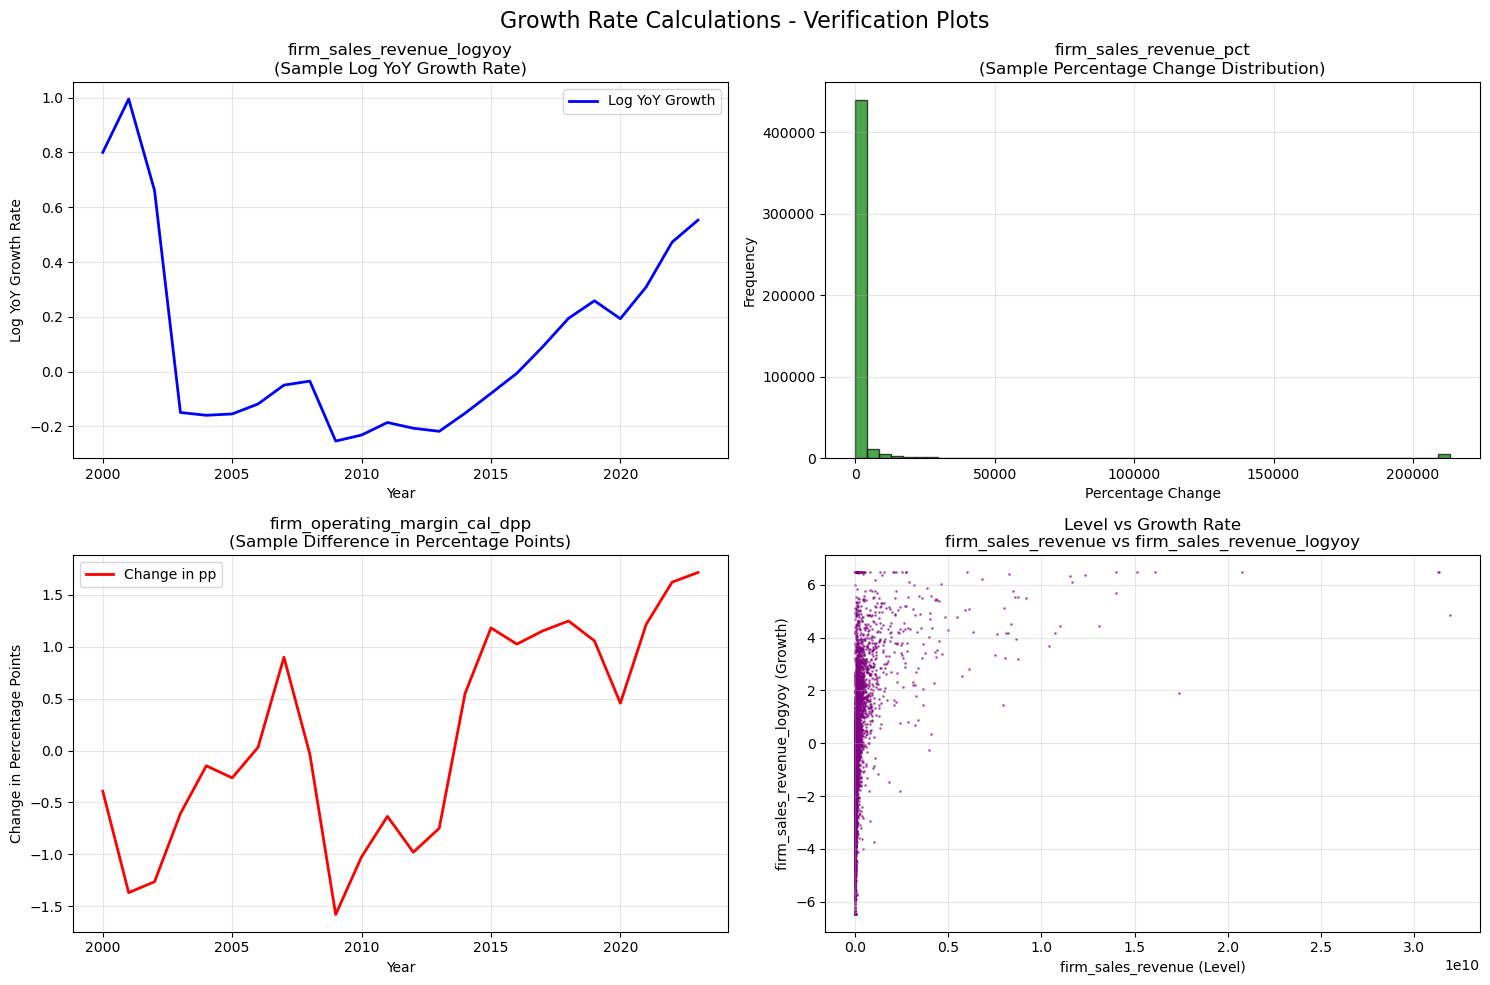


Summary Statistics for Growth Rate Variables:
shape: (10, 7)
┌─────────────────────────────────┬────────┬────────┬──────────┬──────────┬────────────┬───────────┐
│ variable                        ┆ count  ┆ nulls  ┆ mean     ┆ std      ┆ min        ┆ max       │
│ ---                             ┆ ---    ┆ ---    ┆ ---      ┆ ---      ┆ ---        ┆ ---       │
│ str                             ┆ i64    ┆ i64    ┆ f64      ┆ f64      ┆ f64        ┆ f64       │
╞═════════════════════════════════╪════════╪════════╪══════════╪══════════╪════════════╪═══════════╡
│ firm_sales_revenue_logyoy       ┆ 467996 ┆ 197061 ┆ 0.015073 ┆ 2.459123 ┆ -6.482304  ┆ 6.467855  │
│ firm_turnover_logyoy            ┆ 475832 ┆ 189225 ┆ 0.012759 ┆ 2.509446 ┆ -6.875299  ┆ 6.900343  │
│ firm_oper_profit_logyoy         ┆ 305438 ┆ 359619 ┆ 0.018905 ┆ 2.775225 ┆ -13.960044 ┆ 13.918818 │
│ firm_profit_pre_tax_logyoy      ┆ 287664 ┆ 377393 ┆ 0.020899 ┆ 3.036099 ┆ -16.531595 ┆ 15.856679 │
│ firm_profit_net_logyoy     

In [54]:
# Visualization to verify calculated growth rates
print("Creating visualizations to verify growth rate calculations...")

# Convert to pandas for easier plotting
df_plot = df_transformed.to_pandas()

# Get lists of the actual created columns
log_yoy_cols = [col for col in new_columns if col.endswith("_logyoy")]
pct_cols = [col for col in new_columns if col.endswith("_pct")]
dpp_cols = [col for col in new_columns if col.endswith("_dpp")]

print(f"Available columns for plotting:")
print(f"  Log YoY columns: {len(log_yoy_cols)}")
print(f"  Percentage columns: {len(pct_cols)}")
print(f"  DPP columns: {len(dpp_cols)}")

# Create subplots for different types of growth rates
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Growth Rate Calculations - Verification Plots', fontsize=16)

# 1. Plot time series of a sample log YoY growth rate
if log_yoy_cols:
    sample_col = log_yoy_cols[0]
    original_col = sample_col.replace("_logyoy", "")
    
    # Aggregate by year (mean) for plotting
    if original_col in df_plot.columns and sample_col in df_plot.columns:
        yearly_data = df_plot.groupby('year').agg({
            original_col: 'mean',
            sample_col: 'mean'
        }).reset_index()
        
        ax1 = axes[0, 0]
        ax1.plot(yearly_data['year'], yearly_data[sample_col], 'b-', linewidth=2, label='Log YoY Growth')
        ax1.set_title(f'{sample_col}\n(Sample Log YoY Growth Rate)')
        ax1.set_xlabel('Year')
        ax1.set_ylabel('Log YoY Growth Rate')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
    else:
        ax1 = axes[0, 0]
        ax1.text(0.5, 0.5, f'Data not available for\n{sample_col}', 
                ha='center', va='center', transform=ax1.transAxes)
        ax1.set_title('Log YoY Growth Rate (No Data)')

# 2. Plot histogram of a sample percentage change
if pct_cols:
    sample_col = pct_cols[0]
    
    ax2 = axes[0, 1]
    if sample_col in df_plot.columns:
        # Remove extreme outliers for better visualization
        plot_data = df_plot[sample_col].dropna()
        if len(plot_data) > 0:
            q1, q99 = plot_data.quantile([0.01, 0.99])
            plot_data_filtered = plot_data[(plot_data >= q1) & (plot_data <= q99)]
            
            ax2.hist(plot_data_filtered, bins=50, alpha=0.7, color='green', edgecolor='black')
            ax2.set_title(f'{sample_col}\n(Sample Percentage Change Distribution)')
            ax2.set_xlabel('Percentage Change')
            ax2.set_ylabel('Frequency')
            ax2.grid(True, alpha=0.3)
        else:
            ax2.text(0.5, 0.5, 'No data available', ha='center', va='center', transform=ax2.transAxes)
            ax2.set_title('Percentage Change (No Data)')
    else:
        ax2.text(0.5, 0.5, f'Column not found:\n{sample_col}', ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title('Percentage Change (Column Missing)')
else:
    ax2 = axes[0, 1]
    ax2.text(0.5, 0.5, 'No percentage columns available', ha='center', va='center', transform=ax2.transAxes)
    ax2.set_title('Percentage Change (No Columns)')

# 3. Plot time series of a sample difference in percentage points
if dpp_cols:
    sample_col = dpp_cols[0]
    
    ax3 = axes[1, 0]
    if sample_col in df_plot.columns:
        # Aggregate by year (mean) for plotting
        yearly_data = df_plot.groupby('year')[sample_col].mean().reset_index()
        
        ax3.plot(yearly_data['year'], yearly_data[sample_col], 'r-', linewidth=2, label='Change in pp')
        ax3.set_title(f'{sample_col}\n(Sample Difference in Percentage Points)')
        ax3.set_xlabel('Year')
        ax3.set_ylabel('Change in Percentage Points')
        ax3.grid(True, alpha=0.3)
        ax3.legend()
    else:
        ax3.text(0.5, 0.5, f'Column not found:\n{sample_col}', ha='center', va='center', transform=ax3.transAxes)
        ax3.set_title('DPP (Column Missing)')
else:
    ax3 = axes[1, 0]
    ax3.text(0.5, 0.5, 'No DPP columns available', ha='center', va='center', transform=ax3.transAxes)
    ax3.set_title('DPP (No Columns)')

# 4. Correlation plot between original and growth rate
if log_yoy_cols and len(log_yoy_cols) > 0:
    sample_growth_col = log_yoy_cols[0]
    original_col = sample_growth_col.replace("_logyoy", "")
    
    ax4 = axes[1, 1]
    if original_col in df_plot.columns and sample_growth_col in df_plot.columns:
        # Create scatter plot of level vs growth rate
        # Sample data to avoid overplotting
        sample_data = df_plot[[original_col, sample_growth_col]].dropna()
        if len(sample_data) > 0:
            sample_size = min(5000, len(sample_data))
            sample_data = sample_data.sample(n=sample_size, random_state=42)
            
            ax4.scatter(sample_data[original_col], sample_data[sample_growth_col], 
                       alpha=0.5, s=1, color='purple')
            ax4.set_title(f'Level vs Growth Rate\n{original_col} vs {sample_growth_col}')
            ax4.set_xlabel(f'{original_col} (Level)')
            ax4.set_ylabel(f'{sample_growth_col} (Growth)')
            ax4.grid(True, alpha=0.3)
        else:
            ax4.text(0.5, 0.5, 'No paired data available', ha='center', va='center', transform=ax4.transAxes)
            ax4.set_title('Level vs Growth (No Data)')
    else:
        ax4.text(0.5, 0.5, f'Columns not found:\n{original_col}\n{sample_growth_col}', 
                ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Level vs Growth (Columns Missing)')
else:
    ax4 = axes[1, 1]
    ax4.text(0.5, 0.5, 'No log YoY columns available', ha='center', va='center', transform=ax4.transAxes)
    ax4.set_title('Level vs Growth (No Columns)')

plt.tight_layout()
plt.show()

# Summary statistics table
print("\nSummary Statistics for Growth Rate Variables:")
print("=" * 60)

# Create a summary table for the first 10 new columns
summary_stats = []
display_columns = new_columns[:10] if len(new_columns) >= 10 else new_columns

for col in display_columns:
    if col in df_transformed.columns:
        stats = df_transformed.select([
            pl.lit(col).alias("variable"),
            pl.col(col).count().alias("count"),
            pl.col(col).null_count().alias("nulls"),
            pl.col(col).mean().alias("mean"),
            pl.col(col).std().alias("std"),
            pl.col(col).min().alias("min"),
            pl.col(col).max().alias("max")
        ]).to_dicts()[0]
        summary_stats.append(stats)

if summary_stats:
    summary_df = pl.DataFrame(summary_stats)
    print(summary_df)
    print(f"\nDisplaying statistics for {len(summary_stats)} of {len(new_columns)} new variables.")
else:
    print("No growth rate variables found for summary.")

print(f"\nPlot generation completed successfully!")

In [55]:
# Save the transformed dataset and create documentation
print("Saving transformed dataset and creating documentation...")
print("=" * 60)

# 1. Save the transformed dataset
df_transformed.write_parquet(output_path)
print(f"✓ Transformed dataset saved to: {output_path}")
print(f"  - Shape: {df_transformed.shape}")
print(f"  - Original columns: {len(df.columns)}")
print(f"  - New growth rate columns: {len(new_columns)}")
print(f"  - Total columns: {len(df_transformed.columns)}")

# 2. Create documentation for the new variables
doc_path = output_path.replace('.parquet', '_growth_variables_docs.txt')
with open(doc_path, 'w') as f:
    f.write("Growth Rate Variables Documentation\n")
    f.write("=" * 50 + "\n\n")
    f.write(f"Generated on: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Source dataset: {input_path}\n")
    f.write(f"Output dataset: {output_path}\n\n")
    
    f.write("TRANSFORMATION FORMULAS:\n")
    f.write("-" * 30 + "\n")
    f.write("1. Log Year-over-Year Growth (_logyoy):\n")
    f.write("   Formula: X_logyoy_t = ln(X_t) - ln(X_{t-1})\n")
    f.write("   Use: Continuous growth rates for level/index series\n\n")
    
    f.write("2. Percentage Change (_pct):\n")
    f.write("   Formula: X_pct_t = 100*(X_t / X_{t-1} - 1)\n")
    f.write("   Use: Intuitive percentage changes\n\n")
    
    f.write("3. Difference in Percentage Points (_dpp):\n")
    f.write("   Formula: X_dpp_t = X_t - X_{t-1}\n")
    f.write("   Use: Changes in rates, shares, ratios\n\n")
    
    f.write("4. Base-100 Index (_pct):\n")
    f.write("   Formula: X_pct = X - 100\n")
    f.write("   Use: Convert base-100 index to percentage\n\n")
    
    f.write("VARIABLE LISTING:\n")
    f.write("-" * 30 + "\n")
    
    # Group variables by transformation type
    for transform_type in ["_logyoy", "_pct", "_dpp"]:
        vars_of_type = [col for col in new_columns if col.endswith(transform_type)]
        if vars_of_type:
            f.write(f"\n{transform_type.upper()} Variables ({len(vars_of_type)}):\n")
            for var in sorted(vars_of_type):
                f.write(f"  - {var}\n")

print(f"✓ Documentation saved to: {doc_path}")

# 3. Create a summary report
print(f"\n📊 FINAL SUMMARY REPORT")
print("=" * 60)
print(f"Input dataset: {input_path}")
print(f"Output dataset: {output_path}")
print(f"")
print(f"Dataset transformation completed:")
print(f"  • Original shape: {df.shape}")
print(f"  • Final shape: {df_transformed.shape}")
print(f"  • New growth rate variables: {len(new_columns)}")
print(f"")
print(f"Variable breakdown:")
print(f"  • Log YoY growth (_logyoy): {len([c for c in new_columns if c.endswith('_logyoy')])}")
print(f"  • Percentage change (_pct): {len([c for c in new_columns if c.endswith('_pct')])}")
print(f"  • Difference in pp (_dpp): {len([c for c in new_columns if c.endswith('_dpp')])}")
print(f"")
print(f"Key files created:")
print(f"  • {output_path}")
print(f"  • {doc_path}")
print(f"")
print(f"🎉 Growth rate calculations completed successfully!")
print(f"   Ready for econometric analysis in src_03_analysis/")

# 4. Basic validation check
print(f"\n🔍 FINAL VALIDATION CHECK")
print("-" * 30)
# Check that we have reasonable number of non-null observations
sample_growth_col = new_columns[0] if new_columns else None
if sample_growth_col:
    validation_stats = df_transformed.select([
        pl.len().alias("total_rows"),
        pl.col(sample_growth_col).count().alias("non_null_growth"),
        pl.col("year").min().alias("min_year"),
        pl.col("year").max().alias("max_year")
    ]).to_dicts()[0]
    
    print(f"Sample validation ({sample_growth_col}):")
    print(f"  • Total rows: {validation_stats['total_rows']:,}")
    print(f"  • Non-null growth rates: {validation_stats['non_null_growth']:,}")
    print(f"  • Coverage: {validation_stats['non_null_growth']/validation_stats['total_rows']:.1%}")
    print(f"  • Year range: {validation_stats['min_year']} - {validation_stats['max_year']}")
    
    if validation_stats['non_null_growth'] > 0:
        print(f"  ✓ Growth rate calculations appear successful")
    else:
        print(f"  ✗ No growth rate values calculated - check data")
else:
    print("No growth rate variables to validate")

Saving transformed dataset and creating documentation...
✓ Transformed dataset saved to: ../data/data_ready/merged_panel_clean.parquet
  - Shape: (665057, 171)
  - Original columns: 98
  - New growth rate columns: 73
  - Total columns: 171
✓ Documentation saved to: ../data/data_ready/merged_panel_clean_growth_variables_docs.txt

📊 FINAL SUMMARY REPORT
Input dataset: ../data/data_ready/merged_panel_imputed.parquet
Output dataset: ../data/data_ready/merged_panel_clean.parquet

Dataset transformation completed:
  • Original shape: (665057, 98)
  • Final shape: (665057, 171)
  • New growth rate variables: 73

Variable breakdown:
  • Log YoY growth (_logyoy): 23
  • Percentage change (_pct): 24
  • Difference in pp (_dpp): 26

Key files created:
  • ../data/data_ready/merged_panel_clean.parquet
  • ../data/data_ready/merged_panel_clean_growth_variables_docs.txt

🎉 Growth rate calculations completed successfully!
   Ready for econometric analysis in src_03_analysis/

🔍 FINAL VALIDATION CHECK